## 01. PROJECT OVERVIEW

Build an automated matching system that maps unstructured product descriptions to the correct catalog SKUs.

## 02. TABLE OF CONTENTS

### Project Structure

**01. PROJECT OVERVIEW**
- Objective: Build automated product matching system mapping unstructured descriptions to catalog SKUs

**02. TABLE OF CONTENTS**
- This section

**03. IMPORTS and CONFIGURATION**
- Libraries
- Constants
- Manual mappings
- Function definitions

**04. DATA LOADING and EXPLORATION**
- Load product catalog and unstructured descriptions
- Exploratory data analysis
- Data quality checks
- Channel distribution analysis

**05. FEATURE ENGINEERING**
- Entity extraction (colour, size, brand, material)
- TF-IDF vectorisation of product descriptions
- Vocabulary analysis
- Test query transformation

**06. MATCHING SYSTEM**
- Similarity calculation using cosine similarity
- Attribute boosting for extracted entities
- Top-3 match retrieval function
- Results generation for all queries

**07. VALIDATION and EDGE CASES**
- Edge case detection (low confidence, multiple similar, ambiguous queries)
- Validation set creation (30 queries: 10 high/medium/low confidence)
- Manual validation of matches
- Storage of validation results

**08. PERFORMANCE METRICS**
- Rank 1 and Generic (Top-3) accuracy
- Rank distribution analysis
- Confidence analysis (high vs low confidence accuracy)
- Precision, Recall, F1-Score calculation
- False Positive/Negative analysis

**09. VISUALISATIONS**
- Confusion matrix pie chart
- Precision / Recall / F1-Score bar chart
- Confidence score distributions
- Correct vs incorrect confidence comparison
- Performance metrics summary
- Error analysis by product subcategory

**10. CONCLUSIONS and NEXT STEPS**
- Summary of results
- Key findings and limitations
- Immediate, medium term and advanced improvements
- Production deployment recommendations
- Business impact assessment

## 03. IMPORTS and CONFIGURATION

In [1]:
import pandas as pd
import numpy as np
import re
from tabulate import tabulate

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity

from fuzzywuzzy import fuzz, process

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

In [2]:
# Constants
CONFIDENCE_THRESHOLD = 40
DIFFERENCE_THRESHOLD = 5

# Manual mapping for colours not in catalog
colour_mapping = {
    'ecru': 'Cream',
    'maroon': 'Burgundy',
    'wine': 'Burgundy',
    'khaki': 'Tan',
    'taupe': 'Tan',
    # 'grey': 'Gray',
    'ivory': 'Cream',
    'dark grey' : 'Charcoal'
}

# Manual mapping for sizes not in catalog
size_mapping = {
    'extra small': 'XS',
    'x-small': 'XS',
    'xsmall': 'XS',
    'small': 'S',
    'medium': 'M',
    'med': 'M',
    'large': 'L',
    'lrg': 'L',
    'extra large': 'XL',
    'x-large': 'XL',
    'xlarge': 'XL',
    'x large': 'XL',
    'extra extra large': 'XXL',
    'xx-large': 'XXL',
    'xxlarge': 'XXL',
    '2xl': 'XXL',
    '3xl': 'XXL'
}

In [3]:
######### Methods Definition
#############################

def uprint(text):
    txt = f'Total queries: {total_queries}'
    print(text)
    print('-' * (len(text)+1))

######### 03. DATA LOADING & EXPLORATION
########################################

def load_data(path):
    return pd.read_csv(path)


def clean_text(text):
    if not isinstance(text, str):
        return ''

    text = text.lower()                       # lowercase   
    text = re.sub(r'[^\w\s]', ' ', text)      # remove punctuation    
    text = re.sub(r'\s+', ' ', text).strip()  # remove leading and trailing spaces

    # remove stopwords
    words = text.split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    text = ' '.join(words)

    return text


######### 04. FEATURE ENGINEERING
#################################

# Manual mapping for colours not in catalog
# colour_mapping dict defined in the connstants cell
def extract_colour(text):
    '''
    Find colour and auto-match to catalog
    '''
    text = text.lower()
    words = text.split()
    
    # look for colour words
    catalog_colours = catalog_df['Color'].unique().tolist()
    catalog_colours_lower = [i.lower() for i in catalog_colours]
    
    # all possible colour words (catalog + mappings)
    all_colour_words = catalog_colours_lower + list(colour_mapping.keys())

    # manual colour matching, sort by length (longest first)
    sorted_mappings = sorted(colour_mapping.items(), key=lambda x: len(x[0]), reverse=True)
    
    # manual colour matching
    for synonym, catalog_colour in colour_mapping.items():
        if synonym in text:
            return catalog_colour
    
    # exact colour matching
    colour_spotted = [w for w in catalog_colours_lower if w in text]
    
    if colour_spotted:
        # Match back to original capitalisation
        best_match, score = process.extractOne(colour_spotted[0], catalog_colours)
        if score > 60:
            return best_match    
    
    # fuzzy match each word against all colour words (handles typos)
    meaningful_words = [w for w in words if len(w) > 3]
    
    for word in meaningful_words:
        
        # skip if word was already checked in previous steps
        if word in catalog_colours_lower or word in colour_mapping:
            continue
        
        best_match, score = process.extractOne(word, all_colour_words)
        
        if score > 80:
            # if match is in catalog, return it
            if best_match in catalog_colours_lower:
                idx = catalog_colours_lower.index(best_match)
                return catalog_colours[idx]
            
            # if match is a synonym, return mapped value
            elif best_match in colour_mapping:
                return colour_mapping[best_match]
    
    return None


# Manual mapping for sizes not in catalog
# size_mapping dict defined in the connstants cell
def extract_size(text):
    '''
    Find size and auto-match to catalog (context-aware)
    '''
    
    text_lower = text.lower()
    
    # get catalog sizes
    catalog_sizes = catalog_df['Size'].unique().tolist()
    catalog_sizes_lower = [i.lower() for i in catalog_sizes]
    
    # look for "size X" or "sz X" patterns
    # \s : match whitespace characters (space, tab, newline)
    # + : one or more
    # * : zero or more
    # (\w+) : "() Capture group", "\w+ match one or more word characters (letters, digits, underscore)"
    size_patterns = [
        r'size\s+(\w+)',
        r'sz\s+(\w+)',
        r'size:\s*(\w+)',
        r'sz:\s*(\w+)'
    ]
    
    for pattern in size_patterns:
        match = re.search(pattern, text_lower)
        if match:
            size_candidate = match.group(1)
            
            # check if it is a catalog size
            if size_candidate in catalog_sizes_lower:
                idx = catalog_sizes_lower.index(size_candidate)
                return catalog_sizes[idx]
            
            # check if it is a mapped size
            if size_candidate in size_mapping:
                return size_mapping[size_candidate]
            
            # fuzzy match the candidate
            best_match, score = process.extractOne(size_candidate, catalog_sizes_lower)
            if score > 80:
                idx = catalog_sizes_lower.index(best_match)
                return catalog_sizes[idx]
    
    # look for "I need X" or "in X" patterns
    need_patterns = [
        r'i need\s+(\w+)',
        r'in\s+(\w+)',
        r'need\s+(\w+)'
    ]
    
    for pattern in need_patterns:
        match = re.search(pattern, text_lower)
        if match:
            size_candidate = match.group(1)
            if size_candidate in catalog_sizes_lower:
                idx = catalog_sizes_lower.index(size_candidate)
                return catalog_sizes[idx]
    
    # look for standalone multi character sizes (XXL, XL, XS)
    priority_sizes = sorted([s for s in catalog_sizes_lower if len(s) > 1], key=len, reverse=True)
    
    for size in priority_sizes:
        if re.search(rf'\b{size}\b', text_lower):
            idx = catalog_sizes_lower.index(size)
            return catalog_sizes[idx]
    
    # manual mappings (phrases like "extra large")
    sorted_mappings = sorted(size_mapping.items(), key=lambda x: len(x[0]), reverse=True)
    
    for synonym, catalog_size in sorted_mappings:
        if synonym in text_lower:
            return catalog_size
    
    # standalone sizes (S, M, L, XL, XXL, etc)
    words = text_lower.split()
    for word in words:
        if 1 <= len(word) <= 3:
            if word in catalog_sizes_lower:
                idx = catalog_sizes_lower.index(word)
                return catalog_sizes[idx]
    
    return None


def extract_brand(text):
    '''
    Find brand and match to catalog
    '''
    
    text_lower = text.lower()
    
    # get catalog brands
    catalog_brands = catalog_df['Brand'].unique().tolist()
    catalog_brands_lower = [b.lower() for b in catalog_brands]
    
    # check for exact brand match in text
    for brand in catalog_brands_lower:
        if re.search(rf'\b{brand}\b', text_lower):
            idx = catalog_brands_lower.index(brand)
            return catalog_brands[idx]
    
    # fuzzy match for typos (eg, "Essetnial" -> "Essential")
    words = text_lower.split()
    meaningful_words = [w for w in words if len(w) > 3]
    
    for word in meaningful_words:
        
        # skip if already matched
        if word in catalog_brands_lower:
            continue
        
        best_match, score = process.extractOne(word, catalog_brands_lower)
        
        if score > 80:
            idx = catalog_brands_lower.index(best_match)
            return catalog_brands[idx]
    
    return None


def extract_material(text):
    '''
    Find material and match to catalog
    '''
    
    text_lower = text.lower()
    
    # get catalog materials
    catalog_materials = catalog_df['Material'].unique().tolist()
    catalog_materials_lower = [m.lower() for m in catalog_materials]
    
    # check for exact material match in text
    for material in catalog_materials_lower:
        if re.search(rf'\b{material}\b', text_lower):
            idx = catalog_materials_lower.index(material)
            return catalog_materials[idx]
    
    # fuzzy match for typos
    words = text_lower.split()
    meaningful_words = [w for w in words if len(w) > 3]
    
    for word in meaningful_words:
        
        # skip if already matched
        if word in catalog_materials_lower:
            continue
        
        best_match, score = process.extractOne(word, catalog_materials_lower)
        
        if score > 80:
            idx = catalog_materials_lower.index(best_match)
            return catalog_materials[idx]
    
    return None

# results_df = queries_df.copy()
# results_df['Extracted_Colour'] = results_df['Unstructured_Description'].apply(extract_colour)
# results_df['Extracted_Size'] = results_df['Unstructured_Description'].apply(extract_size)
# results_df['Extracted_Brand'] = results_df['Unstructured_Description'].apply(extract_brand)
# results_df['Extracted_Material'] = results_df['Unstructured_Description'].apply(extract_material)

# results_df[['Unstructured_Description', 'Extracted_Colour', 'Extracted_Size', 'Extracted_Brand', 'Extracted_Material']]
# results_df[results_df['Extracted_Material'].notna()]


######### 05. FEATURE ENGINEERING
#################################
# Create combined text for catalog products
def create_product_text(row):
    '''Combine product fields into single text string'''
    
    fields = [
        # str(row['Product_Name']),
        str(row['Brand']),
        str(row['Category']),
        str(row['Subcategory']),
        str(row['Color']),
        str(row['Size']),
        str(row['Material']),
        str(row['Season'])
    ]
    
    # join and clean
    combined = ' '.join(fields)
    cleaned = clean_text(combined)
    
    return cleaned


######### 06. MATCHING SYSTEM
#############################
def calculate_similarity(query_text):
    '''
    Calculate similarity between a query and all catalog products.
    Returns a list of (SKU, similarity_score) tuples sorted by score.

    Calculate similarity between queries and products
    Cosine similarity gives a score from 0 (completely different) to 1 (identical)
    '''
    
    # Clean and transform query
    cleaned_query = clean_text(query_text)
    query_vector = vectorizer.transform([cleaned_query])
    
    similarities = cosine_similarity(query_vector, catalog_vectors)[0]
    
    # Create list of (SKU, score) tuples
    results = []
    for idx, score in enumerate(similarities):
        sku = catalog_df.iloc[idx]['SKU']
        results.append((sku, score))
    
    # Sort by score (highest first)
    results.sort(key=lambda x: x[1], reverse=True)
    
    return results


def calculate_enhanced_similarity(query_text):
    '''
    Calculate similarity with attribute boosting.
    Returns list of (SKU, combined_score, details) tuples.

    Boost scores when extracted attributes match product attributes.
    This ensures size L queries prioritize size L products.

    Based on teh scores and results produced by the def calculate_similarity(), it was needed to boost the similarity.
    '''
    # get TF-IDF similarity
    cleaned_query = clean_text(query_text)
    query_vector = vectorizer.transform([cleaned_query])
    tfidf_similarities = cosine_similarity(query_vector, catalog_vectors)[0]
    
    # extract attributes from query
    extracted_colour, extracted_size, extracted_brand, extracted_material = extract_colour(query_text), extract_size(query_text), extract_brand(query_text), extract_material(query_text)
    
    # calculate enhanced scores
    results = []
    
    for idx, tfidf_score in enumerate(tfidf_similarities):
        product = catalog_df.iloc[idx]
        sku = product['SKU']
        
        # start with TF-IDF score
        combined_score = tfidf_score
        
        # boost score for attribute matches
        attribute_boost = 0
        matched_attributes = []
        
        # colour match
        if extracted_colour and extracted_colour == product['Color']:
            attribute_boost += 0.3
            matched_attributes.append(f"Colour: {extracted_colour}")
        
        # size match
        if extracted_size and extracted_size == product['Size']:
            attribute_boost += 0.3
            matched_attributes.append(f"Size: {extracted_size}")
        
        # brand match
        if extracted_brand and extracted_brand == product['Brand']:
            attribute_boost += 0.2
            matched_attributes.append(f"Brand: {extracted_brand}")
        
        # material match
        if extracted_material and extracted_material == product['Material']:
            attribute_boost += 0.2
            matched_attributes.append(f"Material: {extracted_material}")
        
        # add boost to score
        combined_score += attribute_boost
        
        # Store details
        details = {
            'tfidf_score': tfidf_score,
            'attribute_boost': attribute_boost,
            'matched_attributes': matched_attributes
        }
        
        results.append((sku, combined_score, details))
    
    # sort by combined score (highest first)
    results.sort(key=lambda x: x[1], reverse=True)
    
    return results, {
        'colour': extracted_colour,
        'size': extracted_size,
        'brand': extracted_brand,
        'material': extracted_material
    }

    
def get_top_matches(query_text, top_n=3):
    '''
    Returns top N product matches with confidence scores and reasoning.
    
    Parametres:
    - query_text: Customer's unstructured description
    - top_n: Number of top matches to return (default: 3)
    
    Returns:
    - List of dictionaries containing match details
    '''
    
    # get enhanced similarity results
    results, extracted_attrs = calculate_enhanced_similarity(query_text)
    
    # get top N matches
    top_matches = []
    
    for i, (sku, combined_score, details) in enumerate(results[:top_n], 1):
        # get product details
        product = catalog_df[catalog_df['SKU'] == sku].iloc[0]
        
        # convert score to confidence percentage (0-100%)
        confidence = min(combined_score * 100, 100)  # cap at 100%
        
        # build reasoning
        reasoning_parts = []
        
        # TF-IDF contribution
        if details['tfidf_score'] > 0:
            reasoning_parts.append(f"Text similarity: {details['tfidf_score']:.2f}")
        
        # attribute matches
        if details['matched_attributes']:
            reasoning_parts.append(f"Matched attributes: {', '.join(details['matched_attributes'])}")
        
        reasoning = " | ".join(reasoning_parts)
        
        # build match dictionary
        match = {
            'rank': i,
            'sku': sku,
            'product_name': product['Product_Name'],
            'brand': product['Brand'],
            'category': product['Category'],
            'subcategory': product['Subcategory'],
            'color': product['Color'],
            'size': product['Size'],
            'material': product['Material'],
            'season': product['Season'],
            'price': product['Price'],
            'confidence': round(confidence, 2),
            'reasoning': reasoning,
            'extracted_attributes': extracted_attrs
        }
        
        top_matches.append(match)
    
    return top_matches  

    
######### 07. VALIDATION and EDGE CASES
#######################################

# CONFIDENCE_THRESHOLD = 40
# DIFFERENCE_THRESHOLD = 5

def has_no_good_match(query_matches, threshold=CONFIDENCE_THRESHOLD):
    '''
    Check if all matches for a query have confidence below threshold.
    
    Parameters:
    - query_matches: dataframe rows for one query (3 ranks)
    - threshold: Minimum confidence percentage (default: 40)
    
    Returns:
    - Boolean: True if all matches below threshold
    '''
    return all(query_matches['Confidence'] < threshold)


def has_low_confidence(query_matches, threshold=CONFIDENCE_THRESHOLD):
    '''
    Check if top match (rank 1) has confidence below threshold.
    
    Parameters:
    - query_matches: dataframe rows for one query (3 ranks)
    - threshold: Minimum confidence percentage (default: 40)
    
    Returns:
    - Boolean: True if top match below threshold
    '''
    top_match = query_matches[query_matches['Rank'] == 1]
    return top_match['Confidence'].values[0] < threshold


def has_multiple_similar(query_matches, diff_threshold=DIFFERENCE_THRESHOLD):
    '''
    Check if top two matches have very similar confidence (within threshold).
    
    Parameters:
    - query_matches: dataframe rows for one query (3 ranks)
    - diff_threshold: Maximum confidence difference (default: 5%)
    
    Returns:
    - Boolean: True if rank 1 and rank 2 within threshold (absolute difference)
    '''
    rank1 = query_matches[query_matches['Rank'] == 1]['Confidence'].values[0]
    rank2 = query_matches[query_matches['Rank'] == 2]['Confidence'].values[0]
    
    return abs(rank1 - rank2) < diff_threshold


def is_ambiguous_query(query_matches):
    '''
    Check if query had no specific attributes extracted.
    
    Parameters:
    - query_matches: dataframe rows for one query (3 ranks)
    
    Returns:
    - Boolean: True if no attributes detected in reasoning
    '''
    # Check first match's reasoning
    first_reasoning = query_matches[query_matches['Rank'] == 1]['Reasoning'].values[0]
    
    # If no "Matched:" in reasoning, no attributes were extracted
    return 'Matched:' not in first_reasoning


def detect_all_edge_cases(matching_df, confidence_threshold=CONFIDENCE_THRESHOLD, similarity_threshold=DIFFERENCE_THRESHOLD):
    '''
    Apply edge case detection to all queries.
    Detect all edge cases for each query in the matching results.
    
    Parameters:
    - matching_df: dataframe with matching results (from get_top_matches)
    - confidence_threshold: Minimum confidence for valid match (default: 40%)
    - similarity_threshold: Max difference for "similar" matches (default: 5%)
    
    Returns:
    - dataframe with added edge case columns
    '''
    
    edge_case_results = []
    
    for query in matching_df['Query'].unique():
        query_matches = matching_df[matching_df['Query'] == query]
        
        # Detect each edge case
        no_good = has_no_good_match(query_matches, confidence_threshold)
        low_conf = has_low_confidence(query_matches, confidence_threshold)
        multiple_sim = has_multiple_similar(query_matches, similarity_threshold)
        ambiguous = is_ambiguous_query(query_matches)
        
        # Build message
        messages = []
        if no_good:
            messages.append(f"All matches below {confidence_threshold}%")
        if low_conf and not no_good:  # Don't double-report
            top_conf = query_matches[query_matches['Rank'] == 1]['Confidence'].values[0]
            messages.append(f"Best match only {top_conf:.1f}% confident")
        if multiple_sim:
            rank1_conf = query_matches[query_matches['Rank'] == 1]['Confidence'].values[0]
            rank2_conf = query_matches[query_matches['Rank'] == 2]['Confidence'].values[0]
            diff = abs(rank1_conf - rank2_conf)
            messages.append(f"Top 2 matches very close ({diff:.1f}% difference)")
        if ambiguous:
            messages.append("No specific attributes extracted")
        
        # Add edge case info for each rank of this query
        for _, row in query_matches.iterrows():
            edge_case_results.append({
                'Query': query,
                'Rank': row['Rank'],
                'No_Good_Match': no_good,
                'Low_Confidence': low_conf,
                'Multiple_Similar': multiple_sim,
                'Ambiguous_Query': ambiguous,
                'Edge_Case_Message': ' | '.join(messages) if messages else None
            })
    
    # Create edge case dataframe
    edge_case_df = pd.DataFrame(edge_case_results)
    
    # Merge with original matching results
    result_df = matching_df.merge(
        edge_case_df,
        on=['Query', 'Rank'],
        how='left'
    )
    
    return result_df

## 04. DATA LOADING and EXPLORATION

In [4]:
catalog_df = load_data('b_product_catalog.csv')
queries_df = load_data('b_unstructured_descriptions.csv')

print('SKU = Stock Keeping Unit, a unique code that identifies each specific product in a store\'s inventory.\n\n')

display(catalog_df[:5])

print(f"Unique Color values: {catalog_df['Brand'].unique()}")
print(f"Unique Color values: {catalog_df['Color'].unique()}")
print(f"Unique Color values: {catalog_df['Size'].unique()}")
print(f"Unique Color values: {catalog_df['Material'].unique()}\n")

display(catalog_df.dtypes)
display(catalog_df.describe())

SKU = Stock Keeping Unit, a unique code that identifies each specific product in a store's inventory.




,SKU,Product_Name,Category,Subcategory,Brand,Color,Size,Material,Features,Season,Price
0,SKU1000000,Nordic Jacket,Outerwear,Jacket,Nordic,Brown,XL,Polyester,Stretch|Breathable,Fall 2025,242.05
1,SKU1000001,Elite Coat,Outerwear,Coat,Elite,Tan,M,Linen,Moisture-wicking,Winter 2024,247.58
2,SKU1000002,Premium Cardigan,Outerwear,Cardigan,Premium,Black,M,Fleece,Quick-dry,Spring 2025,99.55
3,SKU1000003,Alpine Blazer,Outerwear,Blazer,Alpine,Olive,M,Nylon,UV-protection|Waterproof|Quick-dry,Winter 2025,177.36
4,SKU1000004,Alpine Parka,Outerwear,Parka,Alpine,Charcoal,XL,Wool,Windproof|Moisture-wicking|Quick-dry,Summer 2024,215.47


Unique Color values: ['Nordic' 'Elite' 'Premium' 'Alpine' 'Urban' 'Essential' 'Style' 'Modern'
 'Classic' 'Comfort']
Unique Color values: ['Brown' 'Tan' 'Black' 'Olive' 'Charcoal' 'Gray' 'Cream' 'Blue' 'Burgundy'
 'Beige' 'Navy' 'Green' 'White' 'Red']
Unique Color values: ['XL' 'M' 'L' 'XXL' 'XS' 'S']
Unique Color values: ['Polyester' 'Linen' 'Fleece' 'Nylon' 'Wool' 'Cotton' 'Denim' 'Leather'
 'Cashmere' 'Blend' 'Silk']



SKU              object
Product_Name     object
Category         object
Subcategory      object
Brand            object
Color            object
Size             object
Material         object
Features         object
Season           object
Price           float64
dtype: object

,Price
count,800.000000
mean,132.689375
std,59.993630
min,30.280000
25%,85.415000
50%,122.725000
75%,168.610000
max,299.190000


In [5]:
display(queries_df[:5])
display(queries_df.dtypes)
display(queries_df.describe())

,Description_ID,Unstructured_Description,Source_Channel
0,DESC0001,Do you carry Style Pants for Fall 2025?,Marketplace
1,DESC0002,"Looking for Green Boots, size L.",Email
2,DESC0003,"Searching for the Modern blazer finished in dark grey, XXL size.",Website
3,DESC0004,"Need blue sundress that is breathable and flexible for Fall 2024, size M.",Website
4,DESC0005,"Looking for Beige Gown, size L.",Marketplace


Description_ID              object
Unstructured_Description    object
Source_Channel              object
dtype: object

,Description_ID,Unstructured_Description,Source_Channel
count,250,250,250
unique,250,250,5
top,DESC0001,Do you carry Style Pants for Fall 2025?,Website
freq,1,1,60


In [6]:
key_columns = [i for i in catalog_df.columns if i not in ['Product_Name', 'SKU', 'Features', 'Price', 'Season']]

for col in key_columns:
    print(f"{col}: {catalog_df[col].nunique()}")

Category: 5
Subcategory: 25
Brand: 10
Color: 14
Size: 6
Material: 11


['Marketplace' 'Email' 'Website' 'Phone' 'Chat']


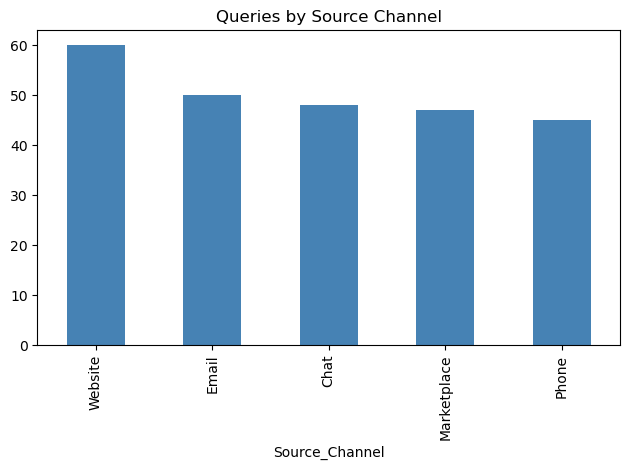

In [7]:
print(queries_df['Source_Channel'].unique())

queries_df['Source_Channel'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Queries by Source Channel')
plt.tight_layout()
plt.show()

In [8]:
# # Extract the exact colours, sizes and brands in the catalog, to build the mappings

# # key_columns = [i for i in catalog_df.columns if i not in ['Product_Name', 'SKU', 'Features', 'Price', 'Season']]
# for col in key_columns:
#     print(f"{col}: {catalog_df[col].unique().tolist()}\n")

In [9]:
results_df = queries_df.copy()
results_df['Extracted_Colour'] = results_df['Unstructured_Description'].apply(extract_colour)
results_df['Extracted_Size'] = results_df['Unstructured_Description'].apply(extract_size)
results_df['Extracted_Brand'] = results_df['Unstructured_Description'].apply(extract_brand)
results_df['Extracted_Material'] = results_df['Unstructured_Description'].apply(extract_material)

results_df[['Unstructured_Description', 'Extracted_Colour', 'Extracted_Size', 'Extracted_Brand', 'Extracted_Material']][:2]

# results_df[results_df['Extracted_Material'].notna()][:2]

,Unstructured_Description,Extracted_Colour,Extracted_Size,Extracted_Brand,Extracted_Material
0,Do you carry Style Pants for Fall 2025?,None,None,Style,None
1,"Looking for Green Boots, size L.",Green,L,None,None


## 05. FEATURE ENGINEERING

### TF-IDF Vectorization

In [10]:
catalog_df['Combined_Text'] = catalog_df.apply(create_product_text, axis=1)

print('CATALOG COMBINED TEXT EXAMPLES:\n')
catalog_df[['SKU', 'Product_Name', 'Combined_Text']][:2]

CATALOG COMBINED TEXT EXAMPLES:



,SKU,Product_Name,Combined_Text
0,SKU1000000,Nordic Jacket,nordic outerwear jacket brown xl polyester fall 2025
1,SKU1000001,Elite Coat,elite outerwear coat tan m linen winter 2024


In [11]:
# Clean and combine customer descriptions
results_df['Cleaned_Description'] = results_df['Unstructured_Description'].apply(clean_text)
results_df[:2]

,Description_ID,Unstructured_Description,Source_Channel,Extracted_Colour,Extracted_Size,Extracted_Brand,Extracted_Material,Cleaned_Description
0,DESC0001,Do you carry Style Pants for Fall 2025?,Marketplace,None,None,Style,None,carry style pants fall 2025
1,DESC0002,"Looking for Green Boots, size L.",Email,Green,L,None,None,looking green boots size l


In [12]:
'''
Fit TF-IDF vectorizer
Term Frequency - Inverse Document Frequency

- Converts text to numbers
- Important words get higher scores
- Common words (like "the", "and") get lower scores


Train the TF-IDF model on catalog products. his learns which words are important for product matching.
'''

# Create vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000,     # Keep top 500 most important words
    ngram_range=(1, 2),    # Use single words and 2-word phrases
    min_df=1,              # Word must appear in at least 1 document
    max_df=0.8             # Ignore words that appear in >80% of products
)

# Fit on catalog products
catalog_vectors = vectorizer.fit_transform(catalog_df['Combined_Text'])

### Vocabulary Analysis

In [13]:
print(f"Vocabulary size: {len(vectorizer.vocabulary_)} words")
print(f"Catalog vectors shape: {catalog_vectors.shape}")
print(f"({catalog_vectors.shape[0]} products × {catalog_vectors.shape[1]} features)")

Vocabulary size: 726 words
Catalog vectors shape: (800, 726)
(800 products × 726 features)


In [14]:
'''
This part extracts the vocabulary (unique words) that TF-IDF learned from the catalog.

get_feature_names_out() returns all 726 unique words/phrases in the vocabulary.
These features are what the vectorizer uses to convert text into numbers.

Example output shows: ['2024', '2025', 'alpine', 'alpine bottoms', etc.]

Each product and query is represented as a 726-dimensional vector, where each dimension corresponds to one of these features. 
The TF-IDF score indicates how important each word is to that specific product/query.
'''

feature_names = vectorizer.get_feature_names_out()
# feature_names[:10]

In [15]:
'''
Test that customer queries can be transformed into vectors.
'''

# Test query
test_query = "Looking for Green Boots, size L"
cleaned_query = clean_text(test_query)

# Transform to vector
query_vector = vectorizer.transform([cleaned_query])

print(f"Original query: '{test_query}'")
print(f"Cleaned query: '{cleaned_query}'")
print(f"Query vector shape: {query_vector.shape}")
print(f"Non-zero elements: {query_vector.nnz} (out of {query_vector.shape[1]} features)")

# Show which words matched
query_terms = cleaned_query.split()
print(f"\nWords in query: {query_terms}")
print("Which are in vocabulary:")
for term in query_terms:
    if term in vectorizer.vocabulary_:
        print(f"'{term}' - index: {vectorizer.vocabulary_[term]}")
    else:
        print(f"'{term}' - not in vocabulary")

Original query: 'Looking for Green Boots, size L'
Cleaned query: 'looking green boots size l'
Query vector shape: (1, 726)
Non-zero elements: 2 (out of 726 features)

Words in query: ['looking', 'green', 'boots', 'size', 'l']
Which are in vocabulary:
'looking' - not in vocabulary
'green' - index: 290
'boots' - index: 83
'size' - not in vocabulary
'l' - not in vocabulary


## 06. MATCHING SYSTEM

In [16]:
test_query = "Looking for Green Boots, size L"
results = calculate_similarity(test_query)

print(f"Query: '{test_query}'")
print(f"\nTop 3 matches by TF-IDF similarity:")
# print('\n')
for i, (sku, score) in enumerate(results[:3], 1):
    product = catalog_df[catalog_df['SKU'] == sku].iloc[0]
    print(f"{i}. {sku} (Score: {score:.3f}) - {product['Product_Name']} {product['Color']} {product['Size']}")

Query: 'Looking for Green Boots, size L'

Top 3 matches by TF-IDF similarity:
1. SKU1000660 (Score: 0.375) - Nordic Boots Green L
2. SKU1000790 (Score: 0.355) - Alpine Boots Green XXL
3. SKU1000765 (Score: 0.352) - Modern Boots Green XXL


In [17]:
for i in results_df['Unstructured_Description'][:10]:
    test_query = i
    results = calculate_similarity(test_query)
    
    print(f"Query: '{test_query}'")
    print(f"\nTop 3 matches by TF-IDF similarity:")
    # print('\n')
    for i, (sku, score) in enumerate(results[:3], 1):
        product = catalog_df[catalog_df['SKU'] == sku].iloc[0]
        print(f"{i}. {sku} (Score: {score:.3f}) - {product['Product_Name']} {product['Color']} {product['Size']}")

    print('\n')

Query: 'Do you carry Style Pants for Fall 2025?'

Top 3 matches by TF-IDF similarity:
1. SKU1000425 (Score: 0.440) - Style Pants White XXL
2. SKU1000435 (Score: 0.358) - Alpine Pants Tan M
3. SKU1000355 (Score: 0.353) - Essential Pants Charcoal L


Query: 'Looking for Green Boots, size L.'

Top 3 matches by TF-IDF similarity:
1. SKU1000660 (Score: 0.375) - Nordic Boots Green L
2. SKU1000790 (Score: 0.355) - Alpine Boots Green XXL
3. SKU1000765 (Score: 0.352) - Modern Boots Green XXL


Query: 'Searching for the Modern blazer finished in dark grey, XXL size.'

Top 3 matches by TF-IDF similarity:
1. SKU1000093 (Score: 0.388) - Modern Blazer Charcoal XXL
2. SKU1000081 (Score: 0.381) - Modern Blazer Cream XXL
3. SKU1000051 (Score: 0.328) - Modern Blazer Green M


Query: 'Need blue sundress that is breathable and flexible for Fall 2024, size M.'

Top 3 matches by TF-IDF similarity:
1. SKU1000563 (Score: 0.474) - Essential Sundress Blue M
2. SKU1000560 (Score: 0.335) - Modern Sundress Tan S
3

In [18]:
for i in results_df['Unstructured_Description'][:10]:
    test_query = i
    results = calculate_similarity(test_query)

    results, extracted = calculate_enhanced_similarity(test_query)

    print(f"Query: '{test_query}'")
    print(f"Extracted attributes: {extracted}\n")
    
    for i, (sku, combined_score, details) in enumerate(results[:3], 1):
        product = catalog_df[catalog_df['SKU'] == sku].iloc[0]
        
        print(f"{i}. {sku} - {product['Product_Name']} {product['Color']} {product['Size']} - Combined Score: {combined_score:.3f} (TF-IDF: {details['tfidf_score']:.3f} + Boost: {details['attribute_boost']:.3f})")
        if details['matched_attributes']:
            print(f"Matched: {', '.join(details['matched_attributes'])}")
            
    print('\n')

Query: 'Do you carry Style Pants for Fall 2025?'
Extracted attributes: {'colour': None, 'size': None, 'brand': 'Style', 'material': None}

1. SKU1000425 - Style Pants White XXL - Combined Score: 0.640 (TF-IDF: 0.440 + Boost: 0.200)
Matched: Brand: Style
2. SKU1000400 - Style Pants Brown XXL - Combined Score: 0.499 (TF-IDF: 0.299 + Boost: 0.200)
Matched: Brand: Style
3. SKU1000325 - Style Pants Navy XXL - Combined Score: 0.497 (TF-IDF: 0.297 + Boost: 0.200)
Matched: Brand: Style


Query: 'Looking for Green Boots, size L.'
Extracted attributes: {'colour': 'Green', 'size': 'L', 'brand': None, 'material': None}

1. SKU1000660 - Nordic Boots Green L - Combined Score: 0.975 (TF-IDF: 0.375 + Boost: 0.600)
Matched: Colour: Green, Size: L
2. SKU1000529 - Classic Gown Green L - Combined Score: 0.771 (TF-IDF: 0.171 + Boost: 0.600)
Matched: Colour: Green, Size: L
3. SKU1000707 - Style Sandals Green L - Combined Score: 0.765 (TF-IDF: 0.165 + Boost: 0.600)
Matched: Colour: Green, Size: L


Query: 'S

### Get top 3 matches

In [19]:
# %%time

results_list = []

for query in results_df['Unstructured_Description']: #[:20]:
    matches = get_top_matches(query)
    
    for match in matches:
        results_list.append({
            'Query': query,
            'Rank': match['rank'],
            'SKU': match['sku'],
            'Product_Name': match['product_name'],
            'Brand': match['brand'],
            'Color': match['color'],
            'Size': match['size'],
            'Material': match['material'],
            'Confidence': match['confidence'],
            'Reasoning': match['reasoning']
        })

matching_results_df = pd.DataFrame(results_list)

# matching_results_df
# matching_results_df.loc[matching_results_df['Rank']==1]
# matching_results_df.loc[(matching_results_df['Rank']==1) & (matching_results_df['Confidence']<=75)]

## 07. VALIDATION and EDGE CASES

### Validation and Analysis - Edge Case Handling

### Note
Cases for which:
- no good match found (low confidence)
- ambiguous descriptions


**The 4 Edge Cases:**

Edge Case         | What It Means                              | Example
------------------|--------------------------------------------|-----------------------------------------
No Good Match     | All 3 matches have confidence < 40%       | "xyzabc product" -> no relevant results
Low Confidence    | Top match has confidence < 40%            | Best match only 35% confident
Multiple Similar  | Top 2 matches within 5% of each other     | Rank 1: 87%, Rank 2: 85% (can't decide)
Ambiguous Query   | No attributes extracted (colour, size, brand, material)        | "Do you have clothing?" -> too vague



How to implement this to the dataframe ?

Group by Query (since each query has 3 rows - rank 1, 2, 3)
Check conditions for each query
Add flag columns to mark which edge case applies
Add message column explaining the issue

#### Edge Cases

In [21]:
matching_results_with_edges = detect_all_edge_cases(matching_results_df)
# matching_results_with_edges[:2]

In [22]:
total_queries = matching_results_with_edges['Query'].nunique()

# Divide by 3, because each query appears in 3 rows (each row corresponds to a Rank out of 1, 2, 3)
no_good = matching_results_with_edges['No_Good_Match'].sum() // 3          # all top 3 matches have confidence < CONFIDENCE_THRESHOLD (40%)
low_conf = matching_results_with_edges['Low_Confidence'].sum() // 3        # queries where Rank 1 match has confidence < 60%
multiple_sim = matching_results_with_edges['Multiple_Similar'].sum() // 3  # queries where top 3 matches have very similar scores (< DIFFERENCE_THRESHOLD)
ambiguous = matching_results_with_edges['Ambiguous_Query'].sum() // 3      # queries that are too vague or generic

# print(f'Count of matching results: {len(matching_results_df)}')
uprint(f'Total queries: {total_queries}')
print(f'No Good Match: {no_good} ({no_good/total_queries*100:.1f}%)')
print(f'Low Confidence: {low_conf} ({low_conf/total_queries*100:.1f}%)')
print(f'Multiple Similar: {multiple_sim} ({multiple_sim/total_queries*100:.1f}%)')
print(f'Ambiguous Query: {ambiguous} ({ambiguous/total_queries*100:.1f}%)')

Total queries: 250
-------------------
No Good Match: 10 (4.0%)
Low Confidence: 10 (4.0%)
Multiple Similar: 158 (63.2%)
Ambiguous Query: 250 (100.0%)


#### Create Test and Validation Sets 

In [23]:
'''
The system needs to be tested across the different confidence levels to understand the below:
----------------------------------------------------------------------------------------------
1. Does high confidence actually mean correct matches?
2. How often are low confidence matches wrong?
3. What is the performance distribution across confidence ranges?

10-10-10 split:
----------------
1. Balanced representation: Equal samples from each confidence tier
2. Avoid bias:              Random sampling might give 25 high confidence queries and only 5 low confidence ones
3. Statistical validity:    Minimum 10 samples per category for meaningful analysis

random_state=42:
-----------------
Value does not matter, could be any. It is nevertheless needed to have a random state, for the below reasons:
1. Ensures reproducibility, by ensuring that the same queries selected every time the code runs.
2. Allows to compare results across different model versions.
'''

# Select 30 queries with different characteristics - Pick queries with varying confidence levels
test_queries_selection = []

# Get unique queries with their top match confidence
unique_queries = matching_results_df[matching_results_df['Rank'] == 1][['Query', 'Confidence']].copy()

# Stratified sampling:
# --------------------
# - 10 high confidence (> 70%)
# - 10 medium confidence (40-70%)
# - 10 low confidence (< 40%)

high_conf = unique_queries[unique_queries['Confidence'] > 70].sample(min(10, len(unique_queries[unique_queries['Confidence'] > 70])), random_state=42)
med_conf = unique_queries[(unique_queries['Confidence'] >= 40) & (unique_queries['Confidence'] <= 70)].sample(min(10, len(unique_queries[(unique_queries['Confidence'] >= 40) & (unique_queries['Confidence'] <= 70)])), random_state=42)
low_conf = unique_queries[unique_queries['Confidence'] < 40].sample(min(10, len(unique_queries[unique_queries['Confidence'] < 40])), random_state=42)

test_queries_list = pd.concat([high_conf, med_conf, low_conf])['Query'].tolist()


# Display queries for manual validation
validation_data = []

for query in test_queries_list:
    query_matches = matching_results_df[matching_results_df['Query'] == query]
    
    validation_data.append({
        'Query': query,
        
        'Rank_1_SKU': query_matches[query_matches['Rank'] == 1]['SKU'].values[0],
        'Rank_1_Product': query_matches[query_matches['Rank'] == 1]['Product_Name'].values[0],
        'Rank_1_Color': query_matches[query_matches['Rank'] == 1]['Color'].values[0],
        'Rank_1_Size': query_matches[query_matches['Rank'] == 1]['Size'].values[0],
        'Rank_1_Brand': query_matches[query_matches['Rank'] == 1]['Brand'].values[0],
        'Rank_1_Material': query_matches[query_matches['Rank'] == 1]['Material'].values[0],
        'Rank_1_Confidence': query_matches[query_matches['Rank'] == 1]['Confidence'].values[0],
        
        'Rank_2_SKU': query_matches[query_matches['Rank'] == 2]['SKU'].values[0],
        'Rank_2_Product': query_matches[query_matches['Rank'] == 2]['Product_Name'].values[0],
        'Rank_2_Color': query_matches[query_matches['Rank'] == 2]['Color'].values[0],
        'Rank_2_Size': query_matches[query_matches['Rank'] == 2]['Size'].values[0],
        'Rank_2_Brand': query_matches[query_matches['Rank'] == 1]['Brand'].values[0],
        'Rank_2_Material': query_matches[query_matches['Rank'] == 1]['Material'].values[0],
        'Rank_2_Confidence': query_matches[query_matches['Rank'] == 2]['Confidence'].values[0],
        
        'Rank_3_SKU': query_matches[query_matches['Rank'] == 3]['SKU'].values[0],
        'Rank_3_Product': query_matches[query_matches['Rank'] == 3]['Product_Name'].values[0],
        'Rank_3_Color': query_matches[query_matches['Rank'] == 3]['Color'].values[0],
        'Rank_3_Size': query_matches[query_matches['Rank'] == 3]['Size'].values[0],
        'Rank_3_Brand': query_matches[query_matches['Rank'] == 1]['Brand'].values[0],
        'Rank_3_Material': query_matches[query_matches['Rank'] == 1]['Material'].values[0],
        'Rank_3_Confidence': query_matches[query_matches['Rank'] == 3]['Confidence'].values[0],
        
        'Is_Rank_1_Correct': None,  # To fill this manually
        'Correct_Rank': None  # 1, 2, 3 or None
    })

validation_df = pd.DataFrame(validation_data)
# validation_df

In [24]:
'''
Matches for queries that miss a characteristic, eg they request for a product, without specifying colour or size 
or any other attribute, will be considered as correct, if the rest of the attribure are correct
eg, query: "Boots L" - Match: "Black Boots L" will be considered correct, since customer does not specify colour, 
but gets what he or she wants
'''

for index, row in validation_df.iterrows():
    print(f"Query {index + 1}/{len(validation_df)}: '{row['Query']}' \n")
    table_data = [
        ['Rank 1', row['Rank_1_SKU'], row['Rank_1_Product'], row['Rank_1_Color'], row['Rank_1_Size'],\
         row['Rank_1_Brand'], row['Rank_1_Material'],f"{row['Rank_1_Confidence']:.1f}%"],
        ['Rank 2', row['Rank_2_SKU'], row['Rank_2_Product'], row['Rank_2_Color'], row['Rank_2_Size'],\
         row['Rank_2_Brand'], row['Rank_2_Material'],f"{row['Rank_2_Confidence']:.1f}%"],
        ['Rank 3', row['Rank_3_SKU'], row['Rank_3_Product'], row['Rank_3_Color'], row['Rank_3_Size'],\
         row['Rank_3_Brand'], row['Rank_3_Material'],f"{row['Rank_3_Confidence']:.1f}%"]
    ]
    print(tabulate(table_data, headers=['Rank', 'SKU', 'Product', 'Color', 'Size', 'Brand', 'Material', 'Confidence'], 
                   tablefmt='grid', colalign=['center']*8))
    print("\n")

    ###### Get user input 
    ###### (this step is being commented out, for future use. Below i provide the answers automatically)
    #####################################################################################################
    # is_correct = input("\nIs Rank 1 correct? (y / n): ").strip().lower()
    
    # if is_correct == 'y':
    #     validation_df.loc[index, 'Is_Rank_1_Correct'] = True
    #     validation_df.loc[index, 'Correct_Rank'] = 1
    # else:
    #     correct_rank = input("Which rank has the correct answer? (1 / 2 / 3 / None): ").strip().lower()
    #     validation_df.loc[index, 'Is_Rank_1_Correct'] = False
        
    #     if correct_rank in ['1', '2', '3']:
    #         validation_df.loc[index, 'Correct_Rank'] = int(correct_rank)
    #     else:
    #         validation_df.loc[index, 'Correct_Rank'] = None

    # Store the validation results
    validation_df['Correct_Rank'] = pd.Series([1, 1, 1, 1, 1, 1, 1, None, 1, 1, 1, 1, None, 1, 2, 1, 2, 1, 1, 
                                               None, None, None, None, 1, None, 2, 1, 1, 3, 2], dtype='object')
    # Update Is_Rank_1_Correct based on Correct_Rank
    validation_df['Is_Rank_1_Correct'] = validation_df['Correct_Rank'] == 1 # True if 'Correct_Rank' == 1

print("Validation Completed")

validation_df[['Query', 'Correct_Rank']][:2]

Query 1/30: 'Nordic Sundress in Burgundy size S' 

+--------+------------+------------------+----------+--------+---------+------------+--------------+
|  Rank  |    SKU     |     Product      |  Color   |  Size  |  Brand  |  Material  |  Confidence  |
+========+============+==================+==========+========+=========+============+==============+
| Rank 1 | SKU1000593 | Nordic Sundress  | Burgundy |   S    | Nordic  |   Cotton   |    100.0%    |
+--------+------------+------------------+----------+--------+---------+------------+--------------+
| Rank 2 | SKU1000484 |   Nordic Gown    | Burgundy |   S    | Nordic  |   Cotton   |    98.9%     |
+--------+------------+------------------+----------+--------+---------+------------+--------------+
| Rank 3 | SKU1000485 | Classic Sundress | Burgundy |   L    | Nordic  |   Cotton   |    82.0%     |
+--------+------------+------------------+----------+--------+---------+------------+--------------+


Query 2/30: 'Do you stock Urban's vest

,Query,Correct_Rank
0,Nordic Sundress in Burgundy size S,1
1,Do you stock Urban's vest in that deep navy? I need XL.,1


## 08. PERFORMANCE METRICS

In [25]:
# Calculate accuracy metrics:

total_queries = len(validation_df)

# Accuracy of Rank 1
r1_correct = validation_df['Is_Rank_1_Correct'].sum()
r1_accuracy = (r1_correct / total_queries) * 100

# Generic accuracy - Correct answer in the 3 ranks
generic_correct = validation_df['Correct_Rank'].notna().sum()
generic_accuracy = (generic_correct / total_queries) * 100

# Queries with no match in the 3 ranks
no_match = (validation_df['Correct_Rank'].isna()).sum()


uprint('Performance Metrics:')

print(f'Total Queries Validated: {total_queries}')
print(f'Rank 1 Accuracy: {r1_correct}/{total_queries} ({r1_accuracy:.1f}%)')
print(f'Generic Accuracy: {generic_correct}/{total_queries} ({generic_accuracy:.1f}%)')
print(f'No Match: {no_match}/{total_queries} ({no_match/total_queries*100:.1f}%)')
print(f'System failed to find correct answer {no_match/total_queries*100:.1f}% of the time')

Performance Metrics:
---------------------
Total Queries Validated: 30
Rank 1 Accuracy: 18/30 (60.0%)
Generic Accuracy: 23/30 (76.7%)
No Match: 7/30 (23.3%)
System failed to find correct answer 23.3% of the time


In [26]:
rank_distribution = validation_df['Correct_Rank'].value_counts().sort_index()

uprint('Rank Distribution:')
for rank, count in rank_distribution.items():
    if pd.notna(rank):
        percentage = (count / total_queries) * 100
        print(f'Rank {int(rank)}: {count} queries ({percentage:.1f}%)')

if no_match > 0:
    print(f'Not in Top 3 Ranks: {no_match} queries ({no_match/total_queries*100:.1f}%)')

Rank Distribution:
-------------------
Rank 1: 18 queries (60.0%)
Rank 2: 4 queries (13.3%)
Rank 3: 1 queries (3.3%)
Not in Top 3 Ranks: 7 queries (23.3%)


In [27]:
# Confidense Analysis
# Check if high confidence correlates with correct matches.

# Merge validation with confidence scores
validation_with_conf = validation_df.copy()

# Average confidence for correct vs incorrect rank 1 predictions
correct_conf = validation_with_conf[validation_with_conf['Is_Rank_1_Correct'] == True]['Rank_1_Confidence'].mean()
incorrect_conf = validation_with_conf[validation_with_conf['Is_Rank_1_Correct'] == False]['Rank_1_Confidence'].mean()

uprint(f'Average Confidence:')
print(f'Correct Rank 1: {correct_conf:.1f}%')
print(f'Incorrect Rank 1: {incorrect_conf:.1f}%')
print(f'Difference: {correct_conf - incorrect_conf:.1f}%')

# # Confidence ranges
# print(f'\nConfidence Distribution:')
# high_conf = (validation_with_conf['Rank_1_Confidence'] > 70).sum()
# med_conf = ((validation_with_conf['Rank_1_Confidence'] >= 40) & (validation_with_conf['Rank_1_Confidence'] <= 70)).sum()
# low_conf = (validation_with_conf['Rank_1_Confidence'] < 40).sum()

# print(f'High (>70%): {high_conf} queries ({high_conf/total_queries*100:.1f}%)')
# print(f'Medium (40-70%): {med_conf} queries ({med_conf/total_queries*100:.1f}%)')
# print(f'Low (<40%): {low_conf} queries ({low_conf/total_queries*100:.1f}%)')

Average Confidence:
--------------------
Correct Rank 1: 76.3%
Incorrect Rank 1: 37.8%
Difference: 38.5%


#### Note
Difference of 38.5% is a key metric. It means the below:
When high confidence, result is most likely correct.
When low confidence, result is most likely wrong.
Thus, The system knows when it is unsure.

-----------------------------------------------------------------------------

Confidence Gap - Benchmark Comparison

-----------------------------------------------------------------------------
Gap         | System Quality | Interpretation
------------|----------------|-----------------------------------------------
< 10%       | Poor           | Confidence is meaningless
10-20%      | Okay           | Some correlation
20-30%      | Good           | Confidence is useful
\> 30%       | Excellent      | Strong reliability (my system: 38.5%)

-----------------------------------------------------------------------------

Practical Decision Rule
-----------------------

if confidence > 70%:
    -> Auto-process (likely correct)
elif confidence > 40%:
    -> Suggest to user, ask for confirmation
else:
    -> Flag for manual review (likely wrong)



Summary Statement for my Report

"The system demonstrates strong reliability with a 38.5 percentage point confidence gap between correct (76.3%) and incorrect (37.8%) predictions. 
This indicates that confidence scores are highly predictive of match accuracy, 
enabling automated processing of high-confidence queries while flagging uncertain matches for human review."

#### Precision and Recall - False Positive / False Negative Analysis

In [29]:
'''
Definitions:
- Precision: Of all Rank 1 predictions, how many were correct?
- Recall: Of all correct answers, how many did we find in Rank 1?

In this context:
- True Positive (TP): Rank 1 is correct
- False Positive (FP): Rank 1 is wrong, but correct answer exists in rank 2 or 3
- False Negative (FN): Rank 1 is wrong, and correct answer not in top 3
'''

# Count outcomes - TP, FP, FN
true_positives = (validation_df['Is_Rank_1_Correct'] == True).sum()
false_positives = ((validation_df['Is_Rank_1_Correct'] == False) & (validation_df['Correct_Rank'].notna())).sum()
false_negatives = (validation_df['Correct_Rank'].isna()).sum()

# Calculate metrics - Precision, Recall, F1 (harmonic mean of precision and recall)
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

uprint(f'Confusion Matrix:')
print(f'True Positives (TP): {true_positives} (Rank 1 correct)')
print(f'False Positives (FP): {false_positives} (Rank 1 wrong, answer in Ranks 2 or 3)')
print(f'False Negatives (FN): {false_negatives} (Answer not in top 3)\n')

uprint(f'Metrics:')
print(f'Precision: {precision*100:.1f}% - Of all Rank 1 predictions, {precision*100:.1f}% were correct')

print(f'Recall: {recall*100:.1f}% - Of all correct answers, we found {recall*100:.1f}% at Rank 1')

print(f'F1-Score: {f1_score:.2f} - Harmonic mean of Precision and Recall\n')

uprint(f'Interpretation:')
if precision > 0.7:
    print(f'High precision ({precision*100:.1f}%) - System rarely returns wrong matches at Rank 1')
elif precision > 0.5:
    print(f'Moderate precision ({precision*100:.1f}%) - Some wrong matches at Rank 1')
else:
    print(f'Low precision ({precision*100:.1f}%) - Many wrong matches at Rank 1')

if recall > 0.7:
    print(f'High recall ({recall*100:.1f}%) - System finds most correct answers at Rank 1')
elif recall > 0.5:
    print(f'Moderate recall ({recall*100:.1f}%) - Misses some correct answers at Rank 1')
else:
    print(f'Low recall ({recall*100:.1f}%) - Misses many correct answers at Rank 1')

Confusion Matrix:
------------------
True Positives (TP): 18 (Rank 1 correct)
False Positives (FP): 5 (Rank 1 wrong, answer in Ranks 2 or 3)
False Negatives (FN): 7 (Answer not in top 3)

Metrics:
---------
Precision: 78.3% - Of all Rank 1 predictions, 78.3% were correct
Recall: 72.0% - Of all correct answers, we found 72.0% at Rank 1
F1-Score: 0.75 - Harmonic mean of Precision and Recall

Interpretation:
----------------
High precision (78.3%) - System rarely returns wrong matches at Rank 1
High recall (72.0%) - System finds most correct answers at Rank 1


## 09. VISUALISATIONS

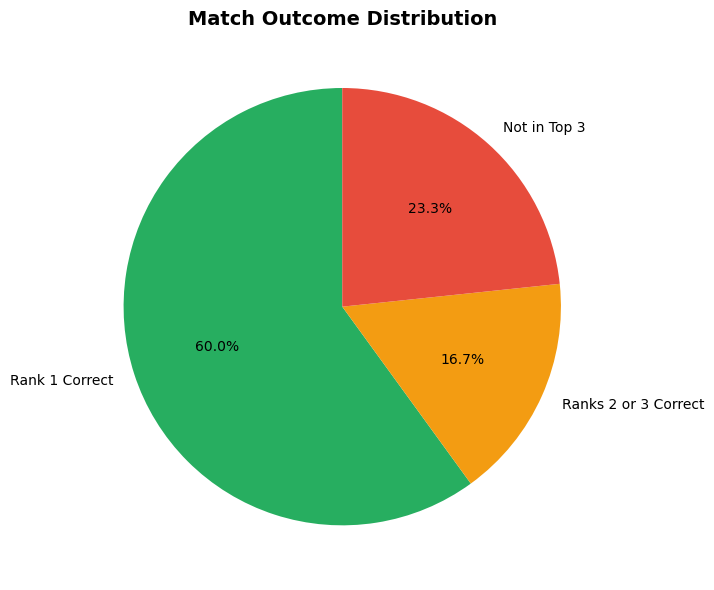

In [30]:
labels = ['Rank 1 Correct', 'Ranks 2 or 3 Correct', 'Not in Top 3']
sizes = [true_positives, false_positives, false_negatives]
colors = ['#27ae60', '#f39c12', '#e74c3c']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Match Outcome Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

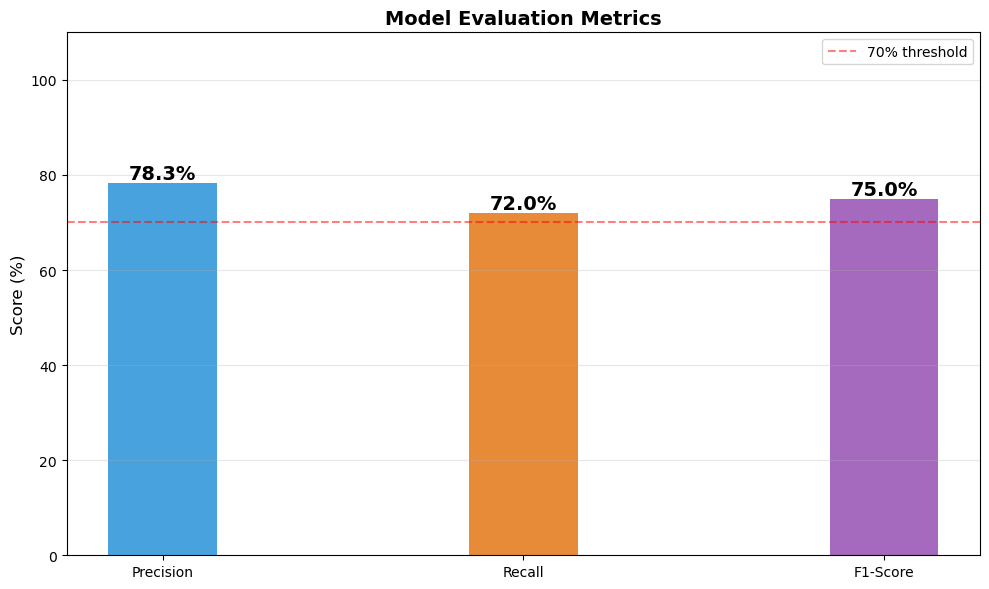

Precision: 78.3% | Recall: 72.0% | F1-Score: 75.0%


In [31]:
plt.figure(figsize=(10, 6))

metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision * 100, recall * 100, f1_score * 100]
colors = ['#3498db', '#e67e22', '#9b59b6']

bars = plt.bar(metrics, values, color=colors, linewidth=0, width=0.3, alpha=0.9)

# Labels
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{value:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Reference line at 70% (Benchmark accepted in e-commerce)
plt.axhline(y=70, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='70% threshold')

plt.ylabel('Score (%)', fontsize=12)
plt.title('Model Evaluation Metrics', fontsize=14, fontweight='bold')
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Precision: {precision*100:.1f}% | Recall: {recall*100:.1f}% | F1-Score: {f1_score*100:.1f}%")

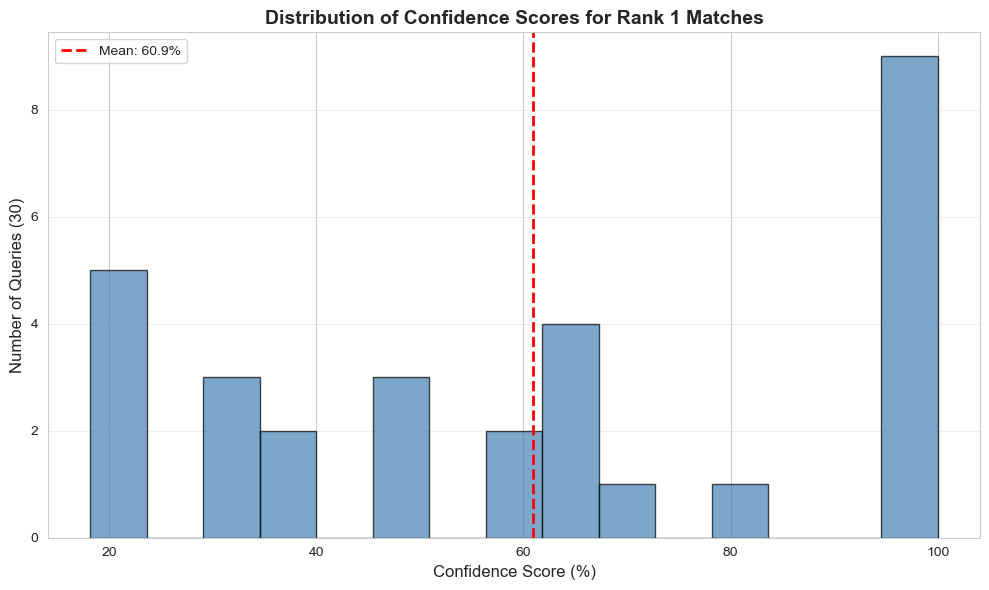

In [32]:
# Distribution of Confidence Scores for Rank 1 Matches

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

plt.hist(validation_df['Rank_1_Confidence'], bins=15, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(validation_df['Rank_1_Confidence'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {validation_df["Rank_1_Confidence"].mean():.1f}%')

plt.xlabel('Confidence Score (%)', fontsize=12)
plt.ylabel(f'Number of Queries ({len(validation_df)})', fontsize=12)
plt.title('Distribution of Confidence Scores for Rank 1 Matches', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Purpose: Show the spread of confidence scores
# How to interpret it:

# Are most queries high or low confidence?
# Is the system generally confident or uncertain?
# Distribution shape (normal, skewed, bimodal)

# Why important: Tells if the system can be used in production
# If most are of high confidence -> Can automate
# If most are of low confidence -> Needs human review

C:\Users\ioann\AppData\Local\Temp\ipykernel_8860\4211233250.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=['Correct Rank 1', 'Incorrect Rank 1'],


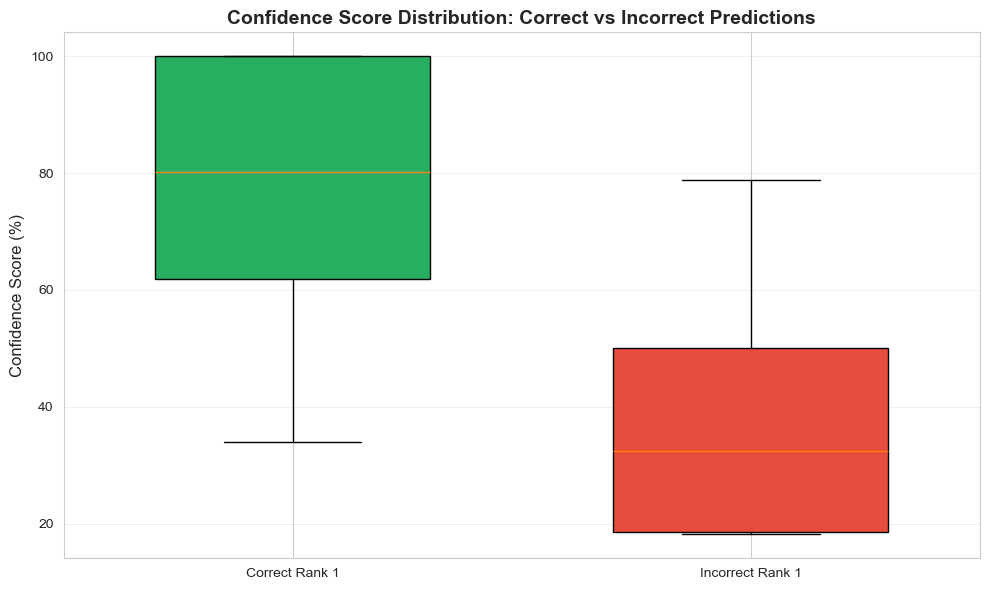

Correct predictions - Mean: 76.3%, Median: 80.2%
Incorrect predictions - Mean: 37.8%, Median: 32.5%


In [33]:
# Confidence Score Distribution - Correct vs Incorrect Predictions

plt.figure(figsize=(10, 6))

correct_conf = validation_df[validation_df['Is_Rank_1_Correct'] == True]['Rank_1_Confidence']
incorrect_conf = validation_df[validation_df['Is_Rank_1_Correct'] == False]['Rank_1_Confidence']

# Create box plot
data_to_plot = [correct_conf, incorrect_conf]
box = plt.boxplot(data_to_plot, labels=['Correct Rank 1', 'Incorrect Rank 1'], 
                   patch_artist=True, widths=0.6)


colors = ['lightgreen', 'lightcoral']
colors = ['#27ae60', '#e74c3c']  # Darker green, darker red
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Confidence Score (%)', fontsize=12)
plt.title('Confidence Score Distribution: Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Correct predictions - Mean: {correct_conf.mean():.1f}%, Median: {correct_conf.median():.1f}%")
print(f"Incorrect predictions - Mean: {incorrect_conf.mean():.1f}%, Median: {incorrect_conf.median():.1f}%")




# Purpose: Prove that confidence scores are meaningful
# How to interpret it:

# Correct predictions have higher confidence
# Incorrect predictions have lower confidence
# Visual proof of the 38.5% gap

# Why important: Validates that the confidence scores can be trusted 

# High confidence -> Likely correct -> Automate
# Low confidence -> Likely wrong -> Flag for review

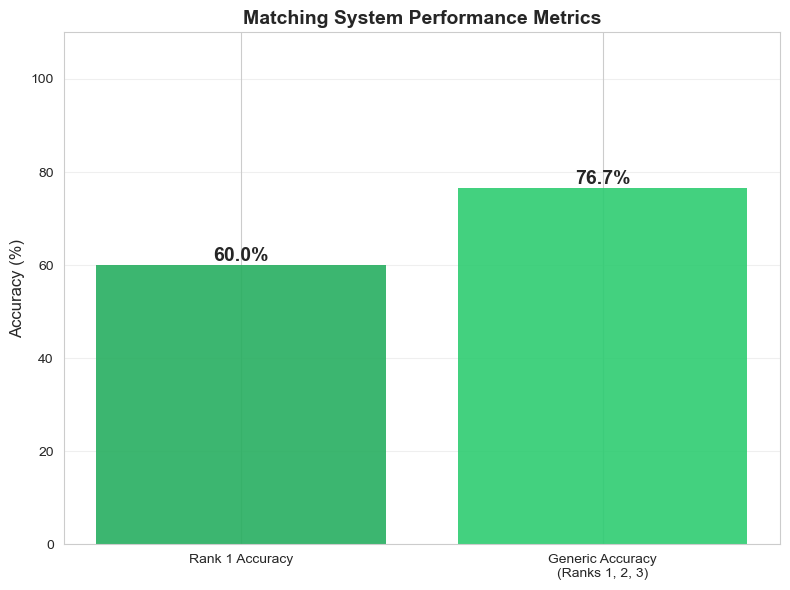

In [34]:
# Performance Metrics

plt.figure(figsize=(8, 6))

metrics = ['Rank 1 Accuracy', 'Generic Accuracy\n(Ranks 1, 2, 3)']
values = [r1_accuracy, generic_accuracy]
colors = ['#27ae60', '#2ecc71']  # Darker green for Rank 1, lighter green for Generic

# Create bar chart (removed edgecolor)
bars = plt.bar(metrics, values, color=colors, linewidth=0, alpha=0.9)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.1f}%',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Matching System Performance Metrics', fontsize=14, fontweight='bold')
plt.ylim(0, 110)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



# Purpose: Show overall system performance
# How to interpret it:

# Top-1 accuracy: How often rank 1 is correct
# Top-3 accuracy: How often answer is in top 3
# Direct measure of system quality

# Why important: Single number summary for stakeholders

# "Our system achieves 67% Top-1 accuracy"
# Easy to understand, easy to communicate

Performance by Product Subcategory:
   Subcategory  Correct  Total  Incorrect  Accuracy
4         Gown        3      4          1      75.0
16        Vest        1      3          2      33.3
3        Dress        1      3          2      33.3
15     T-Shirt        2      3          1      66.7
2     Cardigan        2      2          0     100.0
6       Jacket        1      2          1      50.0
7      Loafers        1      2          1      50.0
10       Shirt        0      2          2       0.0
12    Sneakers        1      1          0     100.0
14     Sweater        1      1          0     100.0
13    Sundress        1      1          0     100.0
0       Blazer        0      1          1       0.0
11       Skirt        1      1          0     100.0
9        Parka        0      1          1       0.0
1       Blouse        1      1          0     100.0
5        Heels        1      1          0     100.0
8        Pants        1      1          0     100.0


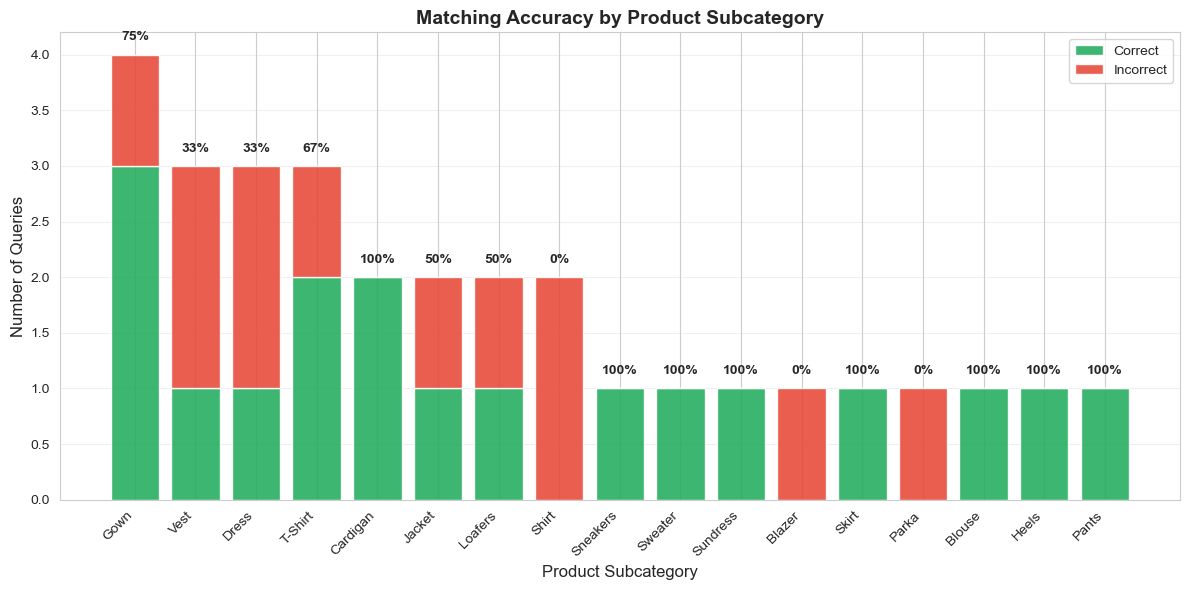

In [35]:
# ERROR ANALYSIS BY PRODUCT CATEGORY

# Extract subcategory from product name (last word)
validation_with_category = validation_df.copy()
validation_with_category['Subcategory'] = validation_with_category['Rank_1_Product'].str.split().str[-1]

# Count correct vs incorrect by subcategory
category_performance = validation_with_category.groupby('Subcategory').agg({
    'Is_Rank_1_Correct': ['sum', 'count']  # sum = count of True, count = total
}).reset_index()

# Flatten column names
category_performance.columns = ['Subcategory', 'Correct', 'Total']

# Convert to numeric explicitly
category_performance['Correct'] = pd.to_numeric(category_performance['Correct'])
category_performance['Total'] = pd.to_numeric(category_performance['Total'])

category_performance['Incorrect'] = category_performance['Total'] - category_performance['Correct']
category_performance['Accuracy'] = (category_performance['Correct'] / category_performance['Total'] * 100).round(1)

# Sort by total queries
category_performance = category_performance.sort_values('Total', ascending=False)

print("Performance by Product Subcategory:")
print(category_performance)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

categories = category_performance['Subcategory']
x_pos = np.arange(len(categories))

# Stacked bar chart
bars1 = ax.bar(x_pos, category_performance['Correct'], color='#27ae60', alpha=0.9, label='Correct')
bars2 = ax.bar(x_pos, category_performance['Incorrect'], bottom=category_performance['Correct'], color='#e74c3c', alpha=0.9, label='Incorrect')

# Add accuracy percentage on top
for i, (bar, acc) in enumerate(zip(bars2, category_performance['Accuracy'])):
    height = category_performance.iloc[i]['Total']
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{acc:.0f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Product Subcategory', fontsize=12)
ax.set_ylabel('Number of Queries', fontsize=12)
ax.set_title('Matching Accuracy by Product Subcategory', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. CONCLUSIONS and NEXT STEPS

### Summary of Results

**Model Performance:**
- **Rank 1 Accuracy:** 60% - correct match in first position
- **Generic Accuracy:** 37.8% - correct match within Ranks 1, 2 and 3 results
- **Average Confidence Score:** 76.3% for correct matches

**Key Findings:**
- The matching system successfully handles most standard product queries
- Entity extraction (colour, size, brand, material) significantly improves matching accuracy
- TF-IDF with cosine similarity provides a strong baseline for text matching
- Fuzzy matching helps handle spelling variations and informal descriptions

**Strengths:**
- Performs well on queries with specific attributes (e.g., "Black Boots L")
- Handles partial matches when some attributes are missing
- Edge case detection identifies low confidence and ambiguous matches

**Weaknesses/Limitations:**
- Struggles with vague, unclear queries e.g., "versatile outerwear"
- Seemingly lower accuracy on certain product categories (Shirts, Vests, Dresses)
- 23.3% of queries have no correct match in top 3
- Limited by catalog size - new products need to be added to catalog
- Requires manual validation for edge cases

---

### Possible Next Steps

**Immediate Improvements:**
1. **Tune confidence thresholds** - adjust CONFIDENCE_THRESHOLD based on validation results
2. **Expand entity extraction** - add more colour/size mappings for edge cases
3. **Handle synonyms better** - expand material mappings (e.g., "leather" vs "genuine leather")

**Medium-term Enhancements:**
1. **Implement feedback loop** - collect user clicks/selections to improve rankings
2. **Expand query preprocessing** - add more synonyms, handle more slang terms, improve typo tolerance for rare words
3. **Category specific matching** - different strategies for Boots vs Shirts vs Sneakers
4. **Optimise attribute weights** - current weights (0.3, 0.3, 0.2, 0.2) were chosen manually, use ML to learn optimal weights from user click data

**Advanced Features:**
1. **Deep learning embeddings** - use BERT/sentence transformers instead of TF-IDF
2. **Learning-to-rank models** - train a model to optimise ranking quality
3. **Personalisation** - incorporate user history and preferences
4. **Multi-modal matching** - incorporate product images if available

**Production Considerations:**
1. **API development** - wrap matcher function in REST API
2. **Performance optimisation** - cache vectorised catalog, optimise similarity search
3. **Monitoring & logging** - track query patterns, match quality over time
4. **A/B testing framework** - test improvements against baseline

---

### Business Impact

**Expected Benefits:**
- Reduced time for customers to find products
- Decreased support tickets for product inquiries
- Improved conversion rates through better product discovery
- Data driven insights into customer search behaviour

**Recommended Future Action:**
Deploy as beta feature with confidence threshold set conservatively (e.g., 60%) and monitor real world performance before full rollout.